# Illustrations for 3D VAE

In [1]:
#Modules

#Modules
import torch
import torch.optim as optim
import pandas as pd
import numpy as np
from torch import nn
import math
import argparse
pi = math.pi

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from torch_geometry.prob_geodesics import ProbGEORCE, ProbGEORCE_Euclidean
from torch_geometry.manifolds import LatentSpaceManifold
from torch_geometry.interpolation import LinearInterpolation, SphericalInterpolation

#Own files
from VAE_surface3d import VAE_3d


## Functions

In [2]:
def circle_fun(theta, mu = np.array([1.,1.,1.]), r=1):
    
    x1 = r*torch.cos(theta)+mu[0]
    x2 = r*torch.sin(theta)+mu[1]
    x3 = torch.zeros(1)+mu[2]
    
    return x1, x2, x3

## Circle 3D

### Hyper-Parameters

In [3]:
N = 100
max_iter = 1000
tol=1e-6
lams = [1.0, 10.0, 100.0]
colors = ['orange', 'pink', 'red', 'blue', 'purple', 'green']

### Loading Data

In [4]:
#Loading data
df = pd.read_csv('Data/circle.csv', index_col=0)
DATA = torch.Tensor(df.values)
DATA = torch.transpose(DATA, 0, 1)

### Loading Model

In [5]:
model = VAE_3d().to('cpu') #Model used
optimizer = optim.Adam(model.parameters(), lr=0.0001)

checkpoint = torch.load('trained_models/circle/circle.pt', map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.eval()

VAE_3d(
  (encoder): Sequential(
    (0): Linear(in_features=3, out_features=100, bias=True)
    (1): ELU(alpha=1.0)
  )
  (mu_net): Sequential(
    (0): Linear(in_features=100, out_features=2, bias=True)
    (1): Identity()
  )
  (var_net): Sequential(
    (0): Linear(in_features=100, out_features=2, bias=True)
    (1): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=100, out_features=3, bias=True)
    (3): Identity()
  )
)

In [6]:
def elbo_reg(curve):

    return model.elbo(curve)

def elbo_evaluate(curve):

    elbo = 0.0
    for i in range(100):
        elbo += model.elbo(curve)
    elbo = torch.mean(elbo)
    
    return elbo

### Defining Data Points and Grid

In [7]:
min_x1, max_x1 = torch.min(DATA[:,0])-0.1, torch.max(DATA[:,0])+0.1
min_x2, max_x2 = torch.min(DATA[:,1])-0.1, torch.max(DATA[:,1])+0.1
min_x3, max_x3 = torch.min(DATA[:,2])-0.1, torch.max(DATA[:,2])+0.1

x1 = torch.linspace(min_x1,max_x1,100)
x2 = torch.linspace(min_x2,max_x2,100)
x3 = torch.linspace(min_x3,max_x3,100)
X1, X2 = torch.meshgrid(x1,x2)

/home/fmry/anaconda3/lib/python3.12/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
#Latent coordinates
zx = torch.tensor(pi).view(1).to('cpu')
zy = torch.tensor(0.).view(1).to('cpu')

#Coordinates on the manifold
x = (torch.tensor(circle_fun(zx))).float()
y = (torch.tensor(circle_fun(zy))).float()

#Mean of approximate posterier
hx = model.h(x)
gx = model.g(hx)

hy = model.h(y)
gy = model.g(hy)

### Defining Manifold

In [9]:
M = LatentSpaceManifold(2, 3, model.h, model.g)

### Computing Heat Map using ELBO

In [10]:
heat_map = []
for u1,v1 in zip(X1,X2):
    vals = []
    for u,v in zip(u1,v1):
        vals.append(-model.elbo_data(torch.stack((u,v, 1.0*torch.ones(1).squeeze())).reshape(-1,3)))
    heat_map.append(torch.stack(vals))
heat_map = torch.stack(heat_map)
heat_map = torch.clip(heat_map, min=-1000.0, max=torch.max(heat_map).item()).detach().numpy()

### Computing Geodesics

In [11]:
Geodesic_latent = ProbGEORCE(M=M, reg_fun = lambda x: torch.sum(torch.zeros_like(x)),
                             init_fun=None,
                             lam=0.0,
                             N=N,
                             tol=tol,
                             max_iter=max_iter,
                             line_search_params = {'rho': 0.5},
                             device='cpu',
                             )
geodesic_curve = Geodesic_latent(hx, hy)
geodesic_elbo = elbo_evaluate(-geodesic_curve)
geodesic_curve = model.g(geodesic_curve)

/home/fmry/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:823: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [12]:
pgeorce_curves = []
pgeorce_elbo = []
for lam in lams:    
    Geodesic = ProbGEORCE_Euclidean(reg_fun = elbo_reg,
                                    init_fun=None,
                                    lam=lam,
                                    N=N,
                                    tol=tol,
                                    max_iter=max_iter,
                                    line_search_params = {'rho': 0.5},
                                    device='cpu',
                                    )
    curve = Geodesic(hx, hy)
    data_curve = model.g(curve)
    
    pgeorce_curves.append(data_curve)
    pgeorce_elbo.append(-elbo_evaluate(curve))

### Plotting Curves

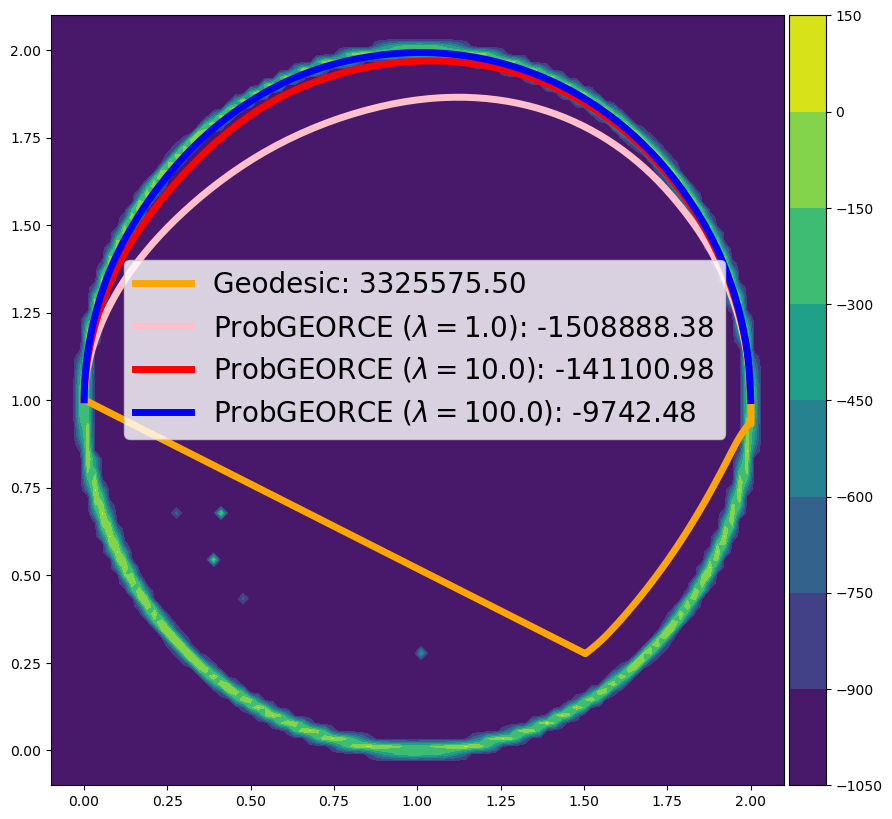

In [13]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

contourf_ = ax.contourf(X1,X2,heat_map.squeeze())

ax.plot(geodesic_curve.detach().numpy()[:,0], geodesic_curve.detach().numpy()[:,1], linewidth=5.0, color=colors[0],
            label=f"Geodesic: {geodesic_elbo:.2f}")
for i,(curve,lam,el) in enumerate(zip(pgeorce_curves,lams,pgeorce_elbo), start=1):
    ax.plot(curve.detach().numpy()[:,0], curve.detach().numpy()[:,1], linewidth=5.0, color=colors[i],
            label=rf"ProbGEORCE ($\lambda=${lam:.1f}): {el:.2f}")

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(contourf_, cax=cax, orientation='vertical')

ax.legend(loc=(0.1,0.45), ncol=1, fontsize=20)
